# Ejemplo de Deep Clustering con Keras
Fuente: https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

En este notebook vamos a seguir un ejemplo de clustering profundo con keras. En él, vamos a tratar de clusterizar los dígitos del MNIST.

**¡Recordad seleccionar un entorno con GPU!**

Para ello, comenzamos, como siempre, con los imports necesarios:

In [ ]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [ ]:
import os
from time import time
import numpy as np
import keras.backend as K
from keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

También vamos a definir la función que calculará el accuracy:

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

Ahora podemos definir nuestro auto-encoder:

In [ ]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here
    
    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


Vamos a cargar los datos. Como estamos trabajando con aprendizaje no supervisado, no necesitamos los conjuntos divididos en train y test y podemos juntar todas las muestras:

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [ ]:
n_clusters = len(np.unique(y))
x.shape

## Base line K-Means

Probamos a realizar un k-means básico para poder comparar cómo mejora el deep clustering:

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [ ]:
acc(y, y_pred_kmeans)

## Creación de un auto-encoder

Ahora definimos cómo queremos configurar nuestro auto-encoder y lo creamos:

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [ ]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png') 

## Pre-entrenamos el auto-encoder

Ya tenemos el auto-encoder definido, ahora vamos a entrenarlo. Pero antes, observad como efectivamente el auto-encoder completo se compone del encoder y el decoder. Primero, el encoder comprime la información a 10 únicos elementos, y después, el decoder, la regenera al estado original, tratando de reducir las pérdidas al mínimo.

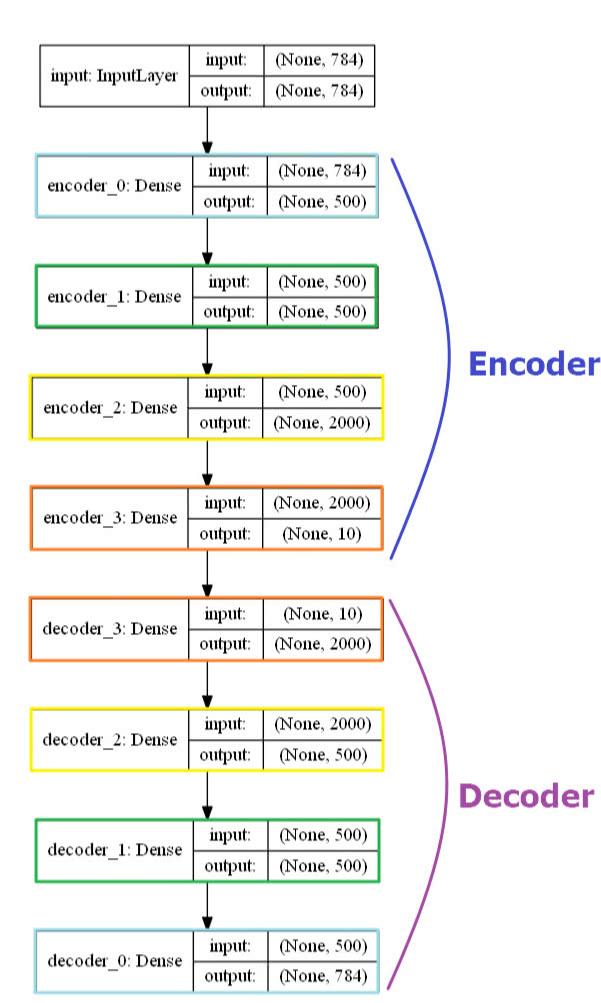

In [ ]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Si quisieramos guardar los pesos del modelo resultante para utilizarlos más adelante, podríamos hacerlo así:

In [ ]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [ ]:
!ls -la results/

Y así los cargaríamos, una vez definido el autoencoder:

In [ ]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Creamos el modelo de clustering

### Capa de clustering: ClusteringLayer

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Añadimos la capa de clustering al **encoder** del modelo anterior, el cual ya está **entrenado** para reconstruir los dígitos:

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

Y lo visualizamos

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png') 

Ahora ya podemos compilar el modelo. Fijaos que en esta ocasión vamos a utilizar como función de pérdidas la Divergencia de Kullback-Leibler:

In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

## Y comenzamos con el algoritmo de Deep Clustering:

### Paso 1: inicializamos los clusters con lo que nos daría el k-means básico

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Paso 2: Aplicamos el modelo de deep clustering (la capa que hemos definido antes)

Calculamos $p_i$ elevando $q_i$ a la segunda potencia y después normalizando por la frecuencia por cluster:

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [ ]:
tol = 0.001 # tolerance threshold to stop training

Comenzamos con el entrenamiento:

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_ = np.round(acc(y, y_pred), 5)
            nmi_ = np.round(nmi(y, y_pred), 5)
            ari_ = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_, nmi_, ari_), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

### Evaluamos el modelo

In [ ]:
# Evaluate
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_ = np.round(acc(y, y_pred), 5)
    nmi_ = np.round(nmi(y, y_pred), 5)
    ari_ = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_, nmi_, ari_), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## BONUS: Modelo para entrenar el autoencoder y las pérdidas de clustering al mismo tiempo

En vez de pre-entrenar el autoencoder y luego utilizar sus salidas para optimizar el clustering, podemos entrenar a la vez el autoencoder y la capa de clustering.

In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png') 

Fijaos como en esta ocasión, el modelo consta tanto de la "rama" que reconstruye los datos originales, la cual aportará sus pérdidas al entrenamiento; como de la rama que realiza el clustering, la cual también aportará sus pérdidas.

Por lo tanto, se optimizarán ambos objetivos a la vez, consiguiendo que el espacio latente que obtiene el autoencoder sea el mejor posible para que las pérdidas de clustering sean las menores posibles.

### Inicializamos los centros de los clusters usando el k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

En este caso, no solo tenemos las pérdidas del clustering (Divergencia de Kullback-Leibler) sino también las pérdidas de reconstrucción (MSE):

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_ = np.round(acc(y, y_pred), 5)
            nmi_ = np.round(nmi(y, y_pred), 5)
            ari_ = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_, nmi_, ari_), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Evaluamos el modelo

In [ ]:
# Evaluate
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_ = np.round(acc(y, y_pred), 5)
    nmi_ = np.round(nmi(y, y_pred), 5)
    ari_ = np.round(ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_, nmi_, ari_), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

# Más recursos:

- https://subscription.packtpub.com/book/programming/9781838821654/13/ch13lvl1sec98/5-unsupervised-clustering-implementation-in-keras

- https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter13-mi-unsupervised/iic-13.5.1.py

- https://towardsdatascience.com/deep-clustering-for-financial-market-segmentation-2a41573618cf

- https://towardsdatascience.com/data-exploration-with-adversarial-autoencoders-311a4e1f271b

- https://towardsdatascience.com/deep-clustering-with-sparse-data-b2eb1bf2922e

- https://www.youtube.com/watch?v=fxUaJSfZMxk

